In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
df = pd.read_csv('../data/DF_modelos/df_industrial_total.csv')

In [3]:
df.head()

,Sector_Economic,consumo,año,fecha,findesemana,festivos,lectivos,COVID,tmed,prec,velmedia,poblacion,PIB,Empleo
0,Indústria,995989,2019.0,2019-01-01,0,1,0,0,8.590909,0.0,1.417647,5628011,14279,604200
1,Indústria,1702091,2019.0,2019-01-02,0,0,0,0,6.617391,0.3,2.152941,5628011,14279,604200
2,Indústria,1826076,2019.0,2019-01-03,0,0,0,0,5.604348,0.1,1.676471,5628011,14279,604200
3,Indústria,1806926,2019.0,2019-01-04,0,0,0,0,5.004348,0.0,1.335294,5628011,28632,604200
4,Indústria,1341548,2019.0,2019-01-05,1,0,0,0,6.173913,0.0,2.247059,5628011,28632,604200


## Paso 1: Preparación de los datos.

In [4]:
df.dtypes

Sector_Economic     object
consumo              int64
año                float64
fecha               object
findesemana          int64
festivos             int64
lectivos             int64
COVID                int64
tmed               float64
prec               float64
velmedia           float64
poblacion            int64
PIB                  int64
Empleo               int64
dtype: object

In [5]:
df.nunique()

Sector_Economic       1
consumo            1966
año                   6
fecha              2008
findesemana           2
festivos              2
lectivos              2
COVID                 3
tmed               1904
prec                540
velmedia           1092
poblacion            11
PIB                  38
Empleo               21
dtype: int64

In [6]:
df.shape

(2008, 14)

In [7]:
# Convertir la columna de fecha a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])

In [8]:
df['Sector_Economic'] = df['Sector_Economic'].astype('category')

### *Transformación variable `Fecha`*

1. Convertir fechas a formato numérico (timestamp)

In [9]:
# Asegúrate de que la columna de fecha está en formato datetime
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y')  # Ajusta el formato según tus datos

# Convertir la columna de fecha a timestamp
df['fecha'] = df['fecha'].astype(np.int64) // 10**9  # Convertir a dias


In [10]:
#Normalizar las columnas numéricas
scaler = StandardScaler()
df[['consumo', 'tmed', 'prec', 'velmedia', 'poblacion', 'PIB']] = scaler.fit_transform(df[['consumo', 'tmed', 'prec', 'velmedia', 'poblacion', 'PIB']])


In [11]:
skew = df.skew(axis=0, numeric_only=True)
skew

consumo        0.759936
año            0.089586
fecha          0.000000
findesemana    0.948621
festivos       4.776828
lectivos      -0.021930
COVID          1.139768
tmed           0.187073
prec           7.407125
velmedia       1.482939
poblacion      0.746403
PIB            0.216043
Empleo         0.454800
dtype: float64

In [12]:
my_list = []
for key,value in enumerate(skew):
    if value > 1:
        my_dict = {key:value}
        my_list.append(my_dict)
        
print(my_list)


[{4: 4.776828378782333}, {6: 1.1397676543831787}, {8: 7.40712474634465}, {9: 1.4829386760641927}]


## Paso 2:  Definición de la arquitectura de la red neuronal

1. Dividir los datos en características y objetivo

In [13]:
# Definir características (X) y objetivo (y)
X = df.drop(columns=['consumo', 'Sector_Economic'])  
y = df['consumo']  

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2. Construir el modelo de red neuronal

In [14]:
# Inicializar el modelo
modelInd = Sequential()

# Añadir la capa de entrada
modelInd.add(Input(shape=(X_train.shape[1],)))  # Define la forma de entrada aquí

# Añadir la primera capa oculta
modelInd.add(Dense(units=64, activation='relu'))

# Añadir una segunda capa oculta (opcional)
modelInd.add(Dense(units=32, activation='relu'))

# Capa de salida
modelInd.add(Dense(units=1))  # Para una regresión, una sola neurona sin función de activación

# Compilar el modelo
modelInd.compile(optimizer='adam', loss='mean_squared_error')


3. Entrenar el modelo

In [15]:
# Entrenar el modelo
history = modelInd.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2014611452723200.0000 - val_loss: 1.2807
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9763 - val_loss: 1.2808
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0155 - val_loss: 1.2808
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8638 - val_loss: 1.2808
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9988 - val_loss: 1.2808
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0185 - val_loss: 1.2808
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9143 - val_loss: 1.2808
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8366 - val_loss: 1.2808
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9189 - val_loss: 1.2808
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0202 - val_loss: 1.2808
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0656 - val_loss: 1.2808
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

4. Evaluar el modelo

In [16]:
test_loss = modelInd.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9313
Test Loss: 0.9915474653244019


## Paso 3: Evaluación del modelo y predicciones

1. Visualizar la pérdida durante el entrenamiento

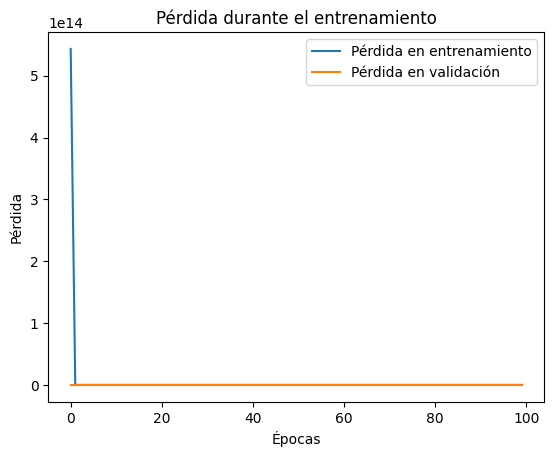

In [17]:
# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

2. Evaluar el modelo en el conjunto de prueba

In [18]:
# Evaluar el modelo en el conjunto de prueba
test_loss = modelInd.evaluate(X_test, y_test)
print(f'Pérdida en el conjunto de prueba: {test_loss}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.9313
Pérdida en el conjunto de prueba: 0.9915474653244019


3. Hacer predicciones

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


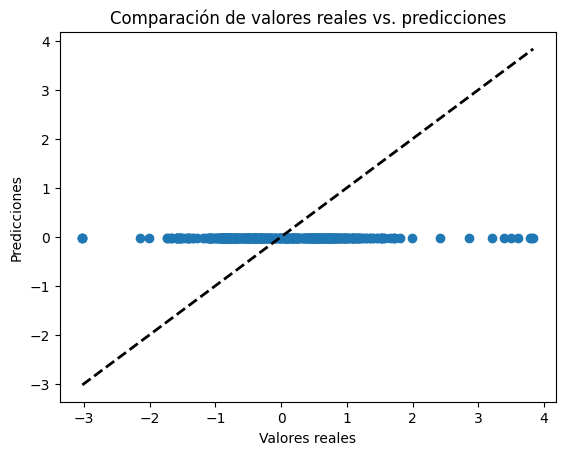

In [19]:
# Hacer predicciones
predicciones = modelInd.predict(X_test)

# Comparar predicciones con los valores reales
plt.scatter(y_test, predicciones)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales vs. predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea de identidad
plt.show()

4. Calcular métricas adicionales

In [20]:
mae = mean_absolute_error(y_test, predicciones)
rmse = mean_squared_error(y_test, predicciones, squared=False)

print(f'Error Absoluto Medio (MAE): {mae}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse}')


Error Absoluto Medio (MAE): 0.7778704282070473
Raíz del Error Cuadrático Medio (RMSE): 0.995764782066782


C:\Users\minip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
#Extraccion del modelo a una crapeta
# Guardar el modelo entrenado en una carpeta
modelInd.save('../models/modelo_industrial.h5')


## Paso 4: Optimización del modelo

Aquí hay algunas estrategias que puedes utilizar para optimizar tu modelo:

#### 1. **Ajuste de Hiperparámetros**

- **Número de Neuronas y Capas**: Experimenta con el número de neuronas en cada capa y la cantidad de capas ocultas. Un modelo más complejo puede capturar mejor patrones en los datos, pero ten cuidado con el sobreajuste.

- **Tasa de Aprendizaje (Learning Rate)**: Ajusta la tasa de aprendizaje del optimizador. Puedes utilizar un optimizador como Adam que permite cambiar dinámicamente la tasa de aprendizaje.


### 2. **Regularización**

- **Dropout**: Introduce capas de `Dropout` para evitar el sobreajuste. Esto apaga aleatoriamente un porcentaje de neuronas durante el entrenamiento, lo que ayuda a que el modelo generalice mejor
- **Regularización L1 o L2**: Aplica técnicas de regularización a las capas densas.


#### 3. **Aumentar el número de épocas**

Aumentar el número de épocas puede ayudar a que el modelo aprenda mejor, pero asegúrate de monitorear la pérdida en el conjunto de validación para evitar el sobreajuste.


#### 4. **Early Stopping**

Implementa `EarlyStopping` para detener el entrenamiento si la pérdida en el conjunto de validación no mejora después de un número específico de épocas. Esto ayuda a evitar el sobreajuste.


#### 5. **Prueba con diferentes optimizadores**

Prueba diferentes optimizadores (como SGD, Adam, RMSprop) para ver si alguno mejora el rendimiento.


### 6. **Evaluar mejoras**

Después de aplicar algunas de estas técnicas, vuelve a evaluar el modelo utilizando el conjunto de prueba y compara el nuevo `Test Loss` y el `RMSE` con los resultados anteriores.
